# Model Explicit Likelihood Inference

In [1]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("ELI")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch, sample_and_save, load_runs
save_dir = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]


2024-02-26 12:06:54.000660: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Import and simulate fiducial

In [8]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_params_fn, get_noise_fn
from montecosmo.models import print_config, condition_on_config_mean, default_config as config
# Build and render model
config.update(a_lpt=0.5, mesh_size=64*np.ones(3, dtype=int))
model = partial(pmrsd_model, **config)
print_config(model)

# Get fiducial parameters
fiduc_params = get_simulator(condition_on_config_mean(partial(model, trace_reparam=True)))(rng_seed=0)

# Condition model on observables
obs_names = ['obs_mesh']
# obs_names = ['obs_mesh','Omega_c_','sigma8_','b1_','b2_','bs_','bnl_']
obs_params = {name: fiduc_params[name] for name in obs_names}
observed_model = condition(model, obs_params)

# Get and vectorize relevant functionals
logp_fn = jit(get_logp_fn(observed_model))
score_fn = jit(get_score_fn(observed_model))
pk_fn = get_pk_fn(**config)
params_fn = get_params_fn(**config)
pk_vfn = jit(vmap(vmap(pk_fn)))
params_vfn = jit(vmap(vmap(get_params_fn)))
print(f"Fiducial {params_fn(**fiduc_params)}")

# CONFIG:
{'mesh_size': array([64, 64, 64]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': False, 'trace_deterministic': False, 'prior_config': {'Omega_c': ['\\Omega_c', 0.25, 0.1], 'sigma8': ['\\sigma_8', 0.831, 0.14], 'b1': ['b_1', 1, 0.5], 'b2': ['b_2', 0, 0.5], 'bs': ['b_s', 0, 0.5], 'bnl': ['b_{\\text{nl}}', 0, 0.5]}, 'lik_config': {'obs_std': 1}}

# INFOS:
cell_size=[10.0, 10.0, 10.0] Mpc/h
delta_k=0.00982 h/Mpc, k_nyquist=0.31416 h/Mpc
mean_gxy_density=1.000 gxy/cell

Fiducial {'Omega_c': 0.25, 'sigma8': 0.831, 'init_mesh': Array([[[ 1.1604729 ,  0.20347655,  1.0551667 , ..., -0.26301157,
          1.5503719 ,  0.4071579 ],
        [-0.9563761 ,  2.1070297 ,  2.3410356 , ...,  1.0548873 ,
          0.7225873 , -0.29850733],
        [ 1.2468987 ,  1.9409857 ,  1.267554  , ..., -1.2260339 ,
          0.15309185, -0.37355894],
        ...,
        [-1.8896822 , -0.20399451,  1.3458786 , ...,  0.4154322 ,
         -1.446

In [9]:
%%timeit
logp_fn(fiduc_params)

2.2 s ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
score_fn(fiduc_params)

13.5 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Run inference

In [23]:
num_samples, max_tree_depth = 243, 8 # 2000, 5; 243, 8; 88575, 3

nuts_kernel = numpyro.infer.NUTS(
    model=observed_model,
    init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    # inverse_mass_matrix=variance_as_invM, 
    adapt_mass_matrix=True,
    # dense_mass=[('Omega_c_base', 'sigma8_base')], # XXX: dense matrix for cosmo params joint, diagonal for the rest
    # step_size=0.01, 
    adapt_step_size=True,
    max_tree_depth=max_tree_depth,)

hmc_kernel = numpyro.infer.HMC(
    model=observed_model,
    init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    # adapt_mass_matrix=False,
    step_size=1e-40, 
    # adapt_step_size=False,
    num_steps=1,)

# # Propose MALA step size based on Chen+2019 http://arxiv.org/abs/1801.02309
# L_smoothness, m_strong_convex = 1, 1 # log density regularity properties
# condition_number = L_smoothness / m_strong_convex
# print(f"MALA step size proposal={1 / (L_smoothness * (config['mesh_size'].prod() * condition_number)**0.5):e}")

# from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA
# mala_kernel = MALA(model=observed_model,
#                     init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
#                     step_size=0.001,)
mcmc = numpyro.infer.MCMC(
    sampler=nuts_kernel,
    num_warmup=num_samples,
    num_samples=num_samples, # for each run
    # num_chains=4,
    # chain_method="vectorized",
    # thinning=1,
    progress_bar=True,)

# Variables to save
extra_fields = ['num_steps'] # e.g. 'num_steps'
save_path = os.path.join(save_dir, f"NUTS_ns{num_samples:d}_mtd{max_tree_depth:d}")
n_runs = 5

In [24]:
mlflow.end_run()
mlflow.start_run(run_name="ELI, NUTS")
mlflow.log_params(config)
mlflow.log_params({'n_runs':n_runs, 'num_samples':num_samples, 'max_tree_depth':max_tree_depth})

In [10]:
mlflow.log_metric('halt',0)
mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields)
mlflow.log_metric('halt',1)

run 0/5 (warmup)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
  0%|          | 0/243 [00:00<?, ?it/s]/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
w

run 1/5


sample: 100%|██████████| 243/243 [30:50<00:00,  7.62s/it, 255 steps of size 4.93e-03. acc. prob=0.81]


run 2/5


sample: 100%|██████████| 243/243 [31:05<00:00,  7.68s/it, 255 steps of size 4.93e-03. acc. prob=0.81]


run 3/5


sample: 100%|██████████| 243/243 [30:59<00:00,  7.65s/it, 255 steps of size 4.93e-03. acc. prob=0.81]


run 4/5


sample: 100%|██████████| 243/243 [31:06<00:00,  7.68s/it, 255 steps of size 4.93e-03. acc. prob=0.81]


run 5/5


sample:  67%|██████▋   | 162/243 [20:44<10:24,  7.71s/it, 255 steps of size 4.93e-03. acc. prob=0.82]

## Analysis

In [26]:
start_run, end_run = 0,5
# Load saved samples
var_names = map(lambda x:x+'_', config['prior_config'].keys())
# var_names = None
post_samples = load_runs(start_run, end_run, save_path, var_names)
# Load extra fields
post_extra = load_runs(start_run, end_run, save_path+"_extra", extra_fields)
n_samples, n_evals = len(post_extra['num_steps']), post_extra['num_steps'].sum()
print(f"total {n_evals=:d}")
mlflow.log_params({'n_samples':n_samples, 'n_evals':n_evals})

loading: NUTS
total run length=12000
loading: NUTS_extra
total run length=12000
total n_evals=371584


### Chain

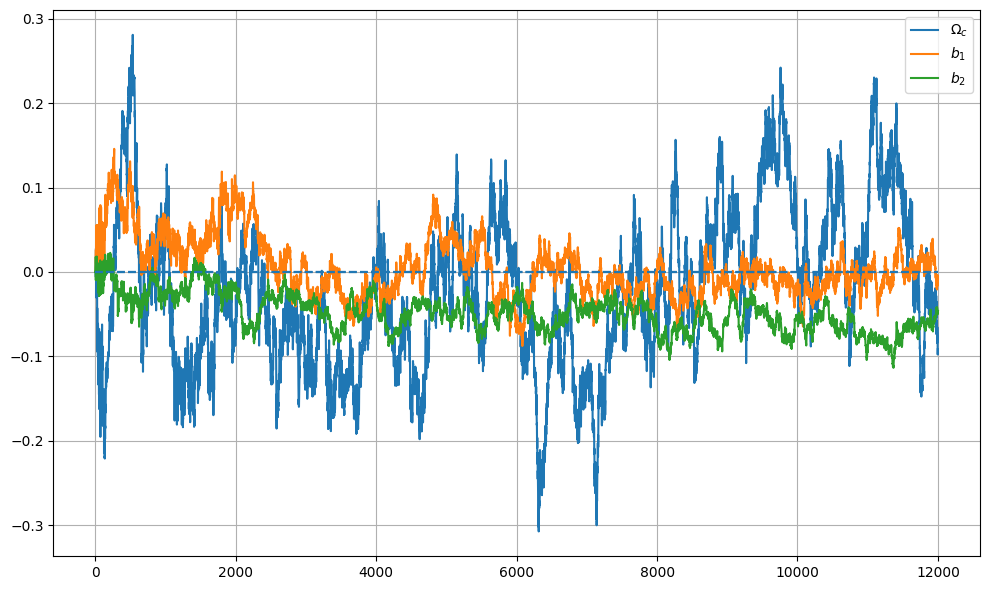

In [54]:
plt.figure(figsize=(10,6))
post_samples_arr = np.array(list((post_samples.values()))).T
labels = ["$"+config['prior_config'][name[:-1]][0]+"$" for name in post_samples]
plt.plot(post_samples_arr[:,:3], label=labels[:3])
plt.hlines([fiduc_params[name] for name in post_samples], 
           xmin=0, xmax=n_samples, 
           ls="--", alpha=0.5,
         #   color=["C"+str(i) for i in range(len(post_samples))],
           )
plt.legend(), plt.grid(), 
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"NUTS_chain.svg")
plt.show();

In [ ]:
prior_simulator = jit(vmap(get_simulator(partial(prior_model, **config))))
prior_samples_ = prior_simulator(jr.split(jr.PRNGKey(44), n_samples))
cosmo_and_init_vfn(prior_samples_)

Removed no burn in
Removed no burn in


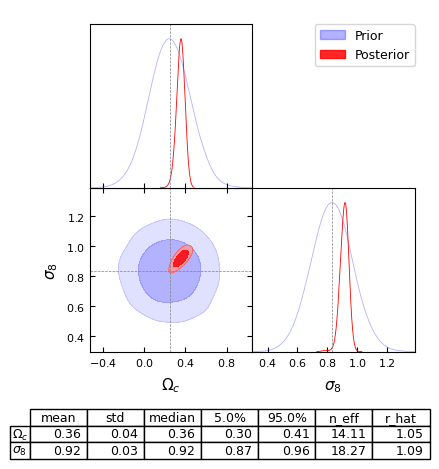

In [11]:
# Diagnostics
# numpyro.diagnostics.print_summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains
summary_dic = numpyro.diagnostics.summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains
summary_arr = [list(list(summary_dic.values())[i].values()) for i in range(len(summary_dic.values()))]

cosmo_post_samples_arr = np.array(list(cosmo_post_samples.values())).T
# Define a custom formatting function to vectorize on summary array
def format_value(value):
    return f"{value:0.2f}"

# Sample from prior
from montecosmo.bricks import cosmo_prior
def cosmo_prior_plate(plate_size):
    with numpyro.plate('cosmo_prior_plate', plate_size):
        cosmo_prior(trace_reparam=True)

plate_size = 10000
cosmo_prior_trace = trace(seed(cosmo_prior_plate, 0)).get_trace(plate_size)
cosmo_prior_samples_arr = np.array([cosmo_prior_trace[key]['value'] for key in cosmo_var_names]).T

# Triangle plot
post_samples_gd = MCSamples(samples=cosmo_post_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
prior_samples_gd = MCSamples(samples=cosmo_prior_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
gd = plots.get_subplot_plotter(subplot_size=None)
# gd.settings.solid_colors='tab10_r'
gd.triangle_plot(roots=[prior_samples_gd, post_samples_gd],
                 markers=fiducial_cosmo_params,
                 filled=True, 
                 legend_labels=["Prior", "Posterior"],
                 line_args=[{'color':'b', 'alpha':0.3},{'color':'r'}],
                 contour_args=[{'color':'b', 'alpha':0.3},{'color':'r'}],)

# Plot summary table
plt.subplot(position=[0,0,1,1]), plt.axis('off')
# gd.fig.axes[-1]('tight'), plt.axis('tight'), plt.subplots_adjust(top=2), plt.gcf().patch.set_visible(False), 
plt.table(cellText=np.vectorize(format_value)(summary_arr),
            # rowLabels=list(summary_dic.keys()),
            rowLabels=["$"+label+"$" for label in cosmo_var_labels], 
            colLabels=list(list(summary_dic.values())[0].keys()),)
plt.tight_layout()
# plt.savefig(save_path+"_contour", bbox_inches='tight') # NOTE: tight bbox required for table
# mlflow.log_figure(plt.gcf(), f"NUTS_contour.svg", bbox_inches='tight')  # NOTE: tight bbox required for table
plt.show();

### Mass matrix

In [ ]:
# Load mass matrix
import pickle
with open(save_path+f"_laststate.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(last_state.adapt_state.step_size, inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

6.9071e-35 {('Omega_c_base', 'init_mesh_base', 'sigma8_base'): Array([4.761905e-05, 4.761905e-05, 4.761905e-05, ..., 4.761905e-05,
       4.761905e-05, 4.761905e-05], dtype=float32)}


In [ ]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    var_variance = post_samples[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_base']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,4))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend(), plt.grid()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_base")
plt.legend(), plt.tight_layout(), plt.grid()
plt.savefig(save_path+"_invMvar");

In [ ]:
# Save posterior variance as inverse mass matrix format
post_variance = []
for var_name in var_names:
    if var_name == 'init_mesh_base':
        var_name = 'init_mesh'
        post_variance = np.concatenate((post_variance, np.ones(post_samples[var_name][0].flatten().shape)))
    else:
        post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))
        post_variance = np.concatenate((post_variance, ))
variance_as_invM = {var_names: post_variance}
print(variance_as_invM)

# with open(save_path+f"_invM.p", 'wb') as file:
#     pickle.dump(post_variance, file, protocol=pickle.HIGHEST_PROTOCOL)

### Init. cond. 

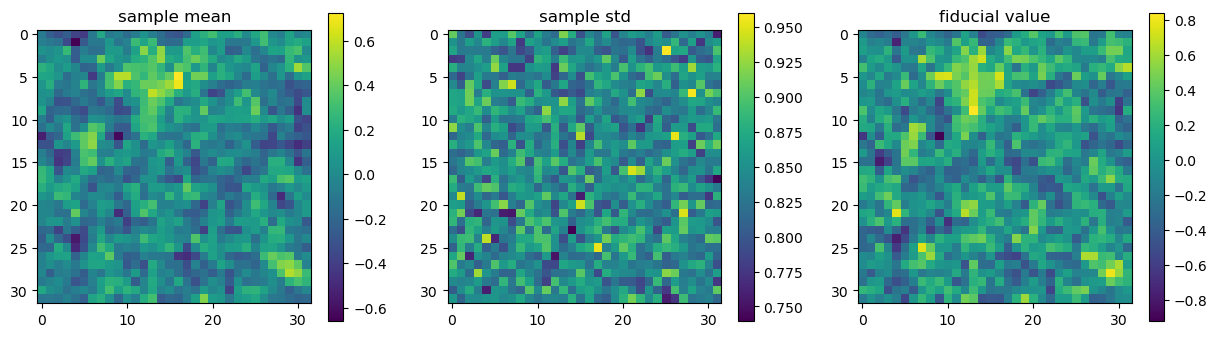

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(post_samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(post_samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiducial_trace['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();

### Spectrum distribution

In [12]:
from jaxpm.utils import power_spectrum
from jaxpm.painting import cic_paint, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get meshes from model trace
init_mesh = fiducial_trace['init_mesh']['value']
biased_mesh = fiducial_trace['biased_mesh']['value']
obs_mesh = fiducial_trace['obs_mesh']['value']
# Get other meshes from model trace particles, compensate for CIC painting convolution
zeros_mesh = jnp.zeros(config['mesh_size'])
lpt_mesh = cic_paint(zeros_mesh, fiducial_trace['lpt_part']['value'])
rsd_mesh = cic_paint(zeros_mesh, fiducial_trace['rsd_part']['value'])

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=config['scale_factor_lpt'])
pk_lin_obs = linear_pk_interp(fiducial_cosmology, scale_factor=config['scale_factor_obs'])

pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=config['box_size'])
pk_lpt = power_spectrum(compensate_cic(lpt_mesh), kmin=0.001, dk=0.01, boxsize=config['box_size'])
pk_rsd = power_spectrum(compensate_cic(rsd_mesh), kmin=0.001, dk=0.01, boxsize=config['box_size'])
pk_biased = power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=0.01, boxsize=config['box_size'])

KeyError: 'biased_mesh'

In [ ]:
n_pks = 1000
pks = np.empty((n_pks, *pk_init[1].shape))
for i_sample in range(n_pks):
    mesh = post_samples['init_mesh'][-i_sample]
    _, pks[i_sample] = power_spectrum(mesh, kmin=0.001, dk=0.01, boxsize=config['box_size'])

pk_023, pk_159, pk_500, pk_841, pk_977 = np.quantile(pks, q=[0.023, 0.159, 0.5, 0.841, 0.977], axis=0)

NameError: name 'pk_init' is not defined

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


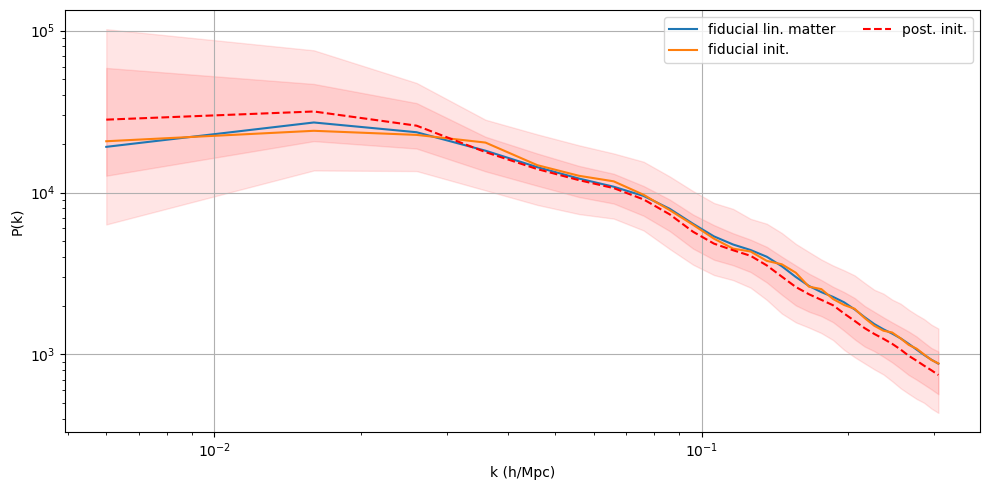

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"fiducial lin. matter")
plt.loglog(pk_init[0], pk_init[1], label=f"fiducial init.")
plt.loglog(pk_init[0], pk_500, color='red', ls='--', label=f"post. init.")
plt.fill_between(pk_init[0], pk_159, pk_841, alpha=0.1, color='red')
plt.fill_between(pk_init[0], pk_023, pk_977, alpha=0.1, color='red')
plt.legend(ncols=2), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.grid(), plt.tight_layout()
plt.savefig(save_path+"_Pkdist");